In [1]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
# read the data
df = pd.read_csv('../input/winequality-red.csv',encoding='utf-8', sep=";")

In [5]:
# Look at the variables
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [9]:
# Look at our target variable: quality
df.describe()
# We don't have any values less than 0
# all the variables are numbers - makes life easier

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


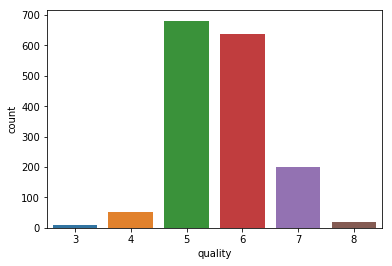

In [8]:
# Look at distribution of target variable

# if it's continuous, we could look at the distribution
#sns.distplot(df_train['SalePrice']);

# Since its (kind of) categorical variable, we look at count
sns.countplot(x="quality",data=df)

In [17]:
#missing data
df.isnull().sum().sort_values(ascending=False)
# no missing data, great!

quality                 0
alcohol                 0
sulphates               0
pH                      0
density                 0
total sulfur dioxide    0
free sulfur dioxide     0
chlorides               0
residual sugar          0
citric acid             0
volatile acidity        0
fixed acidity           0
dtype: int64

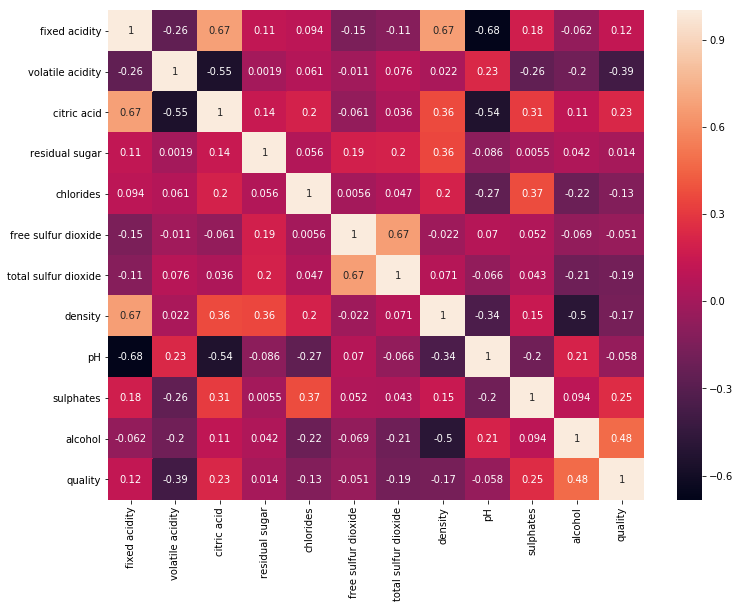

In [13]:
# Overview of Relationship between the input variables/features with the output/target
# Since they are numbers, could do a heatmap
corrmat = df.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, annot=True)

# 1. alcohol content (+ve) and volatile acidity (-ve) stand out, yet it's not super significant
# 2. fixed acidity has a high (-ve) correlation with pH, and (+ve) with citric acid and density 
# but we might not necessarily remove as we have just a few attributes here
# same for free sulfur dioxide and total

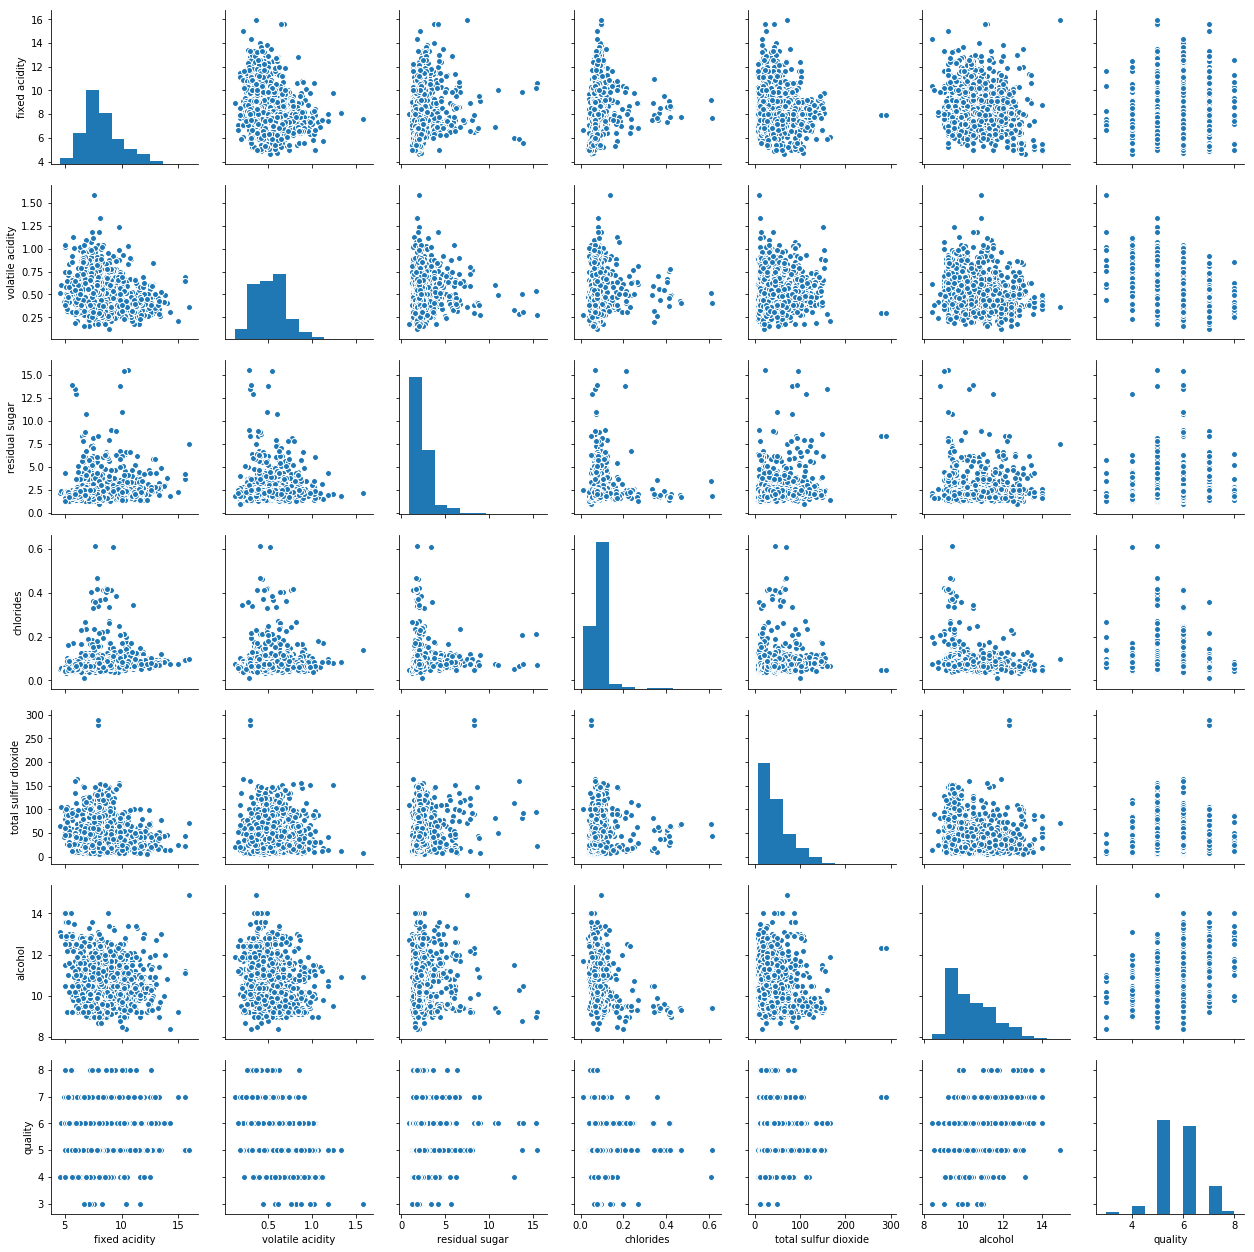

In [20]:
# Let's look at pairplot and see if there's outlier
# remove some of highly correlated features 
cols = ['fixed acidity', 'volatile acidity','residual sugar','chlorides','total sulfur dioxide','alcohol','quality']
sns.pairplot(df[cols], size = 2.5)
plt.show();

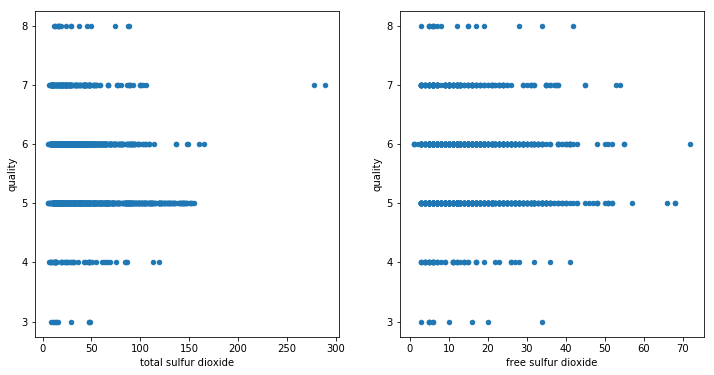

In [23]:
# Two points for total sulfur dioxide (probably for free sulfur as well) are always off the cart
# Let's take a close look
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
df.plot.scatter(x="total sulfur dioxide",y="quality", ax=ax1)
df.plot.scatter(x="free sulfur dioxide",y="quality", ax=ax2)

In [25]:
# Find out who they are
df.sort_values(by="total sulfur dioxide", ascending=False).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1081,7.9,0.30,0.68,8.3,0.050,37.5,289.0,0.99316,3.01,0.51,12.3,7
1079,7.9,0.30,0.68,8.3,0.050,37.5,278.0,0.99316,3.01,0.51,12.3,7
354,6.1,0.21,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,6
1244,5.9,0.29,0.25,13.4,0.067,72.0,160.0,0.99721,3.33,0.54,10.3,6
651,9.8,0.88,0.25,2.5,0.104,35.0,155.0,1.00100,3.41,0.67,11.2,5


In [28]:
# remove them
df = df[df['total sulfur dioxide']<250]

In [ ]:
# Would be good if we could transform the variables to similar range with SD

## Machine Learning - Linear Regression ##
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both __l_1(Lasso)__ and __l_2(Ridge)__ (more common) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [31]:
# Now starting the ML part - predicting quality
# First split the data in the train and test
from sklearn.model_selection import train_test_split

# Split the data into X and y first
X = df.drop("quality", axis=1)
y = df.quality
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3)

In [35]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Ridge Model ###
- Commonly used when there are more predictors variables than observation
- Minimised the sum of residuals square
- The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [36]:
model_ridge = Ridge()

In [43]:
#alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
alphas = [0.05, 0.1, 0.3, 1, 3]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

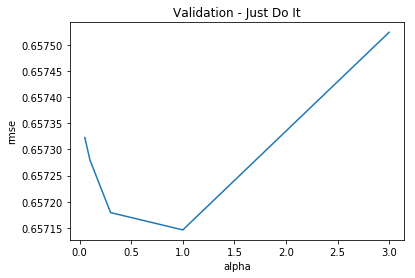

In [44]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
# Looks like 1 is the best value

In [48]:
cv_ridge.min()

0.6571460853153551

### Lasso Model ###
- Optimize the regression coefficient
- Select relevant variables: Might shrinks some features to zero
- automatically choose the best alpha value

In [46]:
# first build the model and let LASSO choose which alpha to use
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [47]:
rmse_cv(model_lasso).mean()

0.6575517654995279

In [50]:
# Check the coeff in the model and see which are the important ones
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

Text(0.5,1,'Coefficients in the Lasso Model')

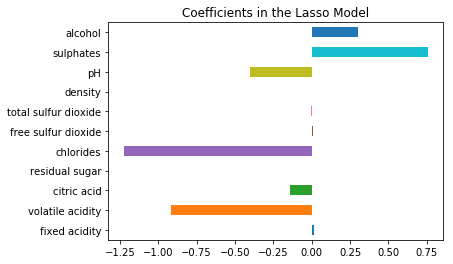

In [53]:
coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")